<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/halloween-seminar-2023/blob/main/1_notebooks/chapter-07-01.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Positional Encoding

## Summary

In languages, the order of the words and their position in a sentence really matters. The meaning of the entire sentence can change if the words are re-ordered. When implementing NLP solutions, recurrent neural networks have an inbuilt mechanism that deals with the order of sequences. The transformer model, however, does not use recurrence or convolution and treats each data point as independent of the other. Hence, positional information is added to the model explicitly to retain the information regarding the order of words in a sentence. Positional encoding is the scheme through which the knowledge of the order of objects in a sequence is maintained.

In this tutorial, you discovered positional encoding in transformers.

Specifically, you learned:

- What is positional encoding, and why it is needed.
- How to implement positional encoding in Python using NumPy
- How to visualize the positional encoding matrix

**Credits. This Notebook is based on the works of the authors quoted in the Reference and Credit Section**

## What Is Positional Encoding and Why Do We Need It?

Position and order of words are the essential parts of any language. They define the grammar and thus the actual semantics of a sentence. Recurrent Neural Networks (RNNs) inherently take the order of word into account; They parse a sentence word by word in a sequential manner. This will integrate the words’ order in the backbone of RNNs.

But the Transformer architecture ditched the recurrence mechanism in favor of multi-head self-attention mechanism. Avoiding the RNNs’ method of recurrence will result in massive speed-up in the training time. And theoretically, it can capture longer dependencies in a sentence.

As each word in a sentence simultaneously flows through the Transformer’s encoder/decoder stack, The model itself doesn’t have any sense of position/order for each word. Consequently, there’s still the need for a way to incorporate the order of the words into our model.

One possible solution to give the model some sense of order is to add a piece of information to each word about its position in the sentence. We call this “piece of information”, the **positional encoding**.

The first idea that might come to mind is to assign a number to each time-step within the [0, 1] range in which 0 means the first word and 1 is the last time-step. One of the problems this approach will introduce is that you can’t figure out how many words are present within a specific range. In other words, "index delta" doesn’t have consistent meaning across different sentences.

Another idea is to assign a number to each time-step linearly. That is, the first word is given “1”, the second word is given “2”, and so on. The problem with this approach is that not only the values could get quite large, but also our model can face sentences longer than the ones in training. In addition, our model may not see any sample with one specific length which would hurt generalization of our model.

Ideally, the following criteria should be satisfied:

- It should output a **unique encoding for each time-step** (word’s position in a sentence)
- Distance between any two time-steps **should be consistent across sentences with different lengths**.
- Our model should **generalize to longer sentences without any efforts**. 
- Its values should be **bounded**.
- It must be **deterministic**.

The encoding proposed by the authors of the famous paper *"Attention is all you need"* (see Reference Section) is a simple technique which satisfies all of those criteria. 

First of all, it isn’t a single number. Instead, it’s a $d$-dimensional vector that contains information about a specific position in a sentence. And secondly, this encoding is not integrated into the model itself. Instead, this vector is used to equip each word with information about its position in a sentence. In other words, we enhance the model’s input to inject the order of words.

## A Quick Run-Through of the Trigonometric Sine Function

This is a quick recap of sine functions; you can work equivalently with cosine functions. The function’s range is [-1,+1]. The frequency of this waveform is the number of cycles completed in one second. The wavelength is the distance over which the waveform repeats itself. The wavelength and frequency for different waveforms are shown below:

<div>
<img src='../1-notebooks/pic/chapter-07-01-01.png'  width="600">
</div>

(source: Machine Learning Mastery, see Reference Section)

## Positional Encoding Layer in Transformers

Ok, so let’s dive straight into this. Suppose you have an input sequence of length $L$ and require the position of the 
$k^{th}$ object within this sequence. The positional encoding is given by sine and cosine functions of varying frequencies:

\begin{equation}
P(k, 2i) = \sin \left( \frac{k}{n^{2i/d}} \right)
\end{equation}

\begin{equation}
P(k, 2i+1) = \cos \left( \frac{k}{n^{2i/d}} \right)
\end{equation}

Here:

- $k$ : Position of an object in the input sequence, $0 \le k \le L/2$

- $d$ : Dimension of the output embedding space;

- $P(k, j)$ : Position function for mapping a position $k$ 
 in the input sequence to index $(k, j)$
 of the positional matrix

- $n$ : User-defined scalar, set to 10,000 by the authors of *Attention Is All You Need*.

- $i$ : Used for mapping to column indices $0 \le i < d/2$, with a single value of $i$ maps to both sine and cosine functions


In the above expression, you can see that even positions correspond to a sine function and odd positions correspond to cosine functions.

$$
\vec{p_t} = \begin{bmatrix} 
\sin({\omega_1}.t)\\ 
\cos({\omega_1}.t)\\ 
\\
\sin({\omega_2}.t)\\ 
\cos({\omega_2}.t)\\ 
\\
\vdots\\ 
\\
\sin({\omega_{d/2}}.t)\\ 
\cos({\omega_{d/2}}.t) 
\end{bmatrix}_{\, d \times 1}
$$

Let's see a very simple code to generate a positional encoding using the proposed algorithm. 

The function `getPositionEncoding` uses nested loops to calculate the positional encoding values for each position in the sequence.
- The outer loop iterates over the **positions** in the sequence ($k$).
- The inner loop iterates over **half of the dimensions** ($d/2$) of the positional encoding vector. This is because the encoding typically consists of pairs of sine and cosine values.
- denominator is calculated as $n$ raised to the power of ($2 \cdot i/d$). This term controls the **frequency** of the sine and cosine functions for each dimension of the positional encoding vector.
- For each dimension of the vector, $P[k, 2 \cdot i]$ is set to $\sin\,(k/denominator)$ and $P[k, 2 \cdot i+1]$ is set to $\cos\,(k/denominator)$. These values vary based on the position $k$ and the dimension $i$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
 
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P
 
P = getPositionEncoding(seq_len=4, d=6, n=10000)
print(P)

[[ 0.          1.          0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.04639922  0.99892298  0.00215443  0.99999768]
 [ 0.90929743 -0.41614684  0.0926985   0.99569422  0.00430886  0.99999072]
 [ 0.14112001 -0.9899925   0.1387981   0.9903207   0.00646326  0.99997911]]


## What Is the Final Output of the Positional Encoding Layer?

The positional encoding layer sums the positional vector with the word encoding and outputs this matrix for the subsequent layers. The entire process is shown below.

<div>
<img src='../1-notebooks/pic/chapter-07-01-02.png'  width="600">
</div>

(source: Machine Learning Mastery, see Reference Section)

## The intuition

You may wonder how this combination of sines and cosines could ever represent a position/order? It is actually quite simple, Suppose you want to represent a number in binary format, how will that be?

\begin{align}
  0: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} & & 
  8: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} \\
  1: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} & & 
  9: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} \\ 
  2: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} & & 
  10: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} \\ 
  3: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} & & 
  11: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} \\ 
  4: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} & & 
  12: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} \\
  5: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} & & 
  13: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} \\
  6: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} & & 
  14: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} \\
  7: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} & & 
  15: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} \\
\end{align}

You can spot the rate of change between different bits. The LSB bit is alternating on every number, the second-lowest bit is rotating on every two numbers, and so on. Sinusoidal functions are used as a sort of equivalent to alternating bits. Moreover, By decreasing their frequencies, we can go from red bits to orange ones.

## Understanding the Positional Encoding Matrix

To better understand the positional encoding, let’s start by looking at the sine wave for different positions with n=10,000 and d=512.

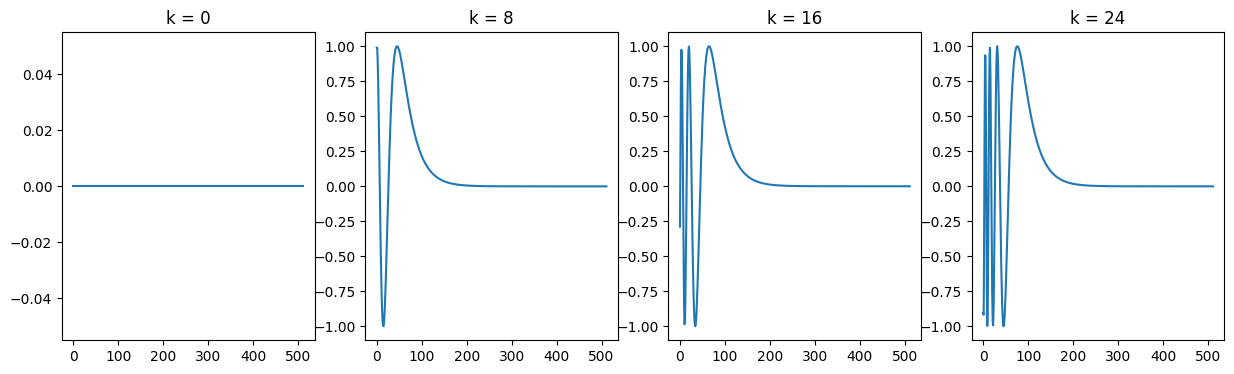

In [8]:
def plotSinusoid(k, d=512, n=10000):
    i = np.arange(0, d, 1)
    denominator = np.power(n, 2*i/d)
    y = np.sin(k/denominator)
    plt.plot(i, y)
    plt.title('k = ' + str(k))
 
fig = plt.figure(figsize=(15, 4))    
for n in range(4):
    plt.subplot(141 + n)
    plotSinusoid(8*n)

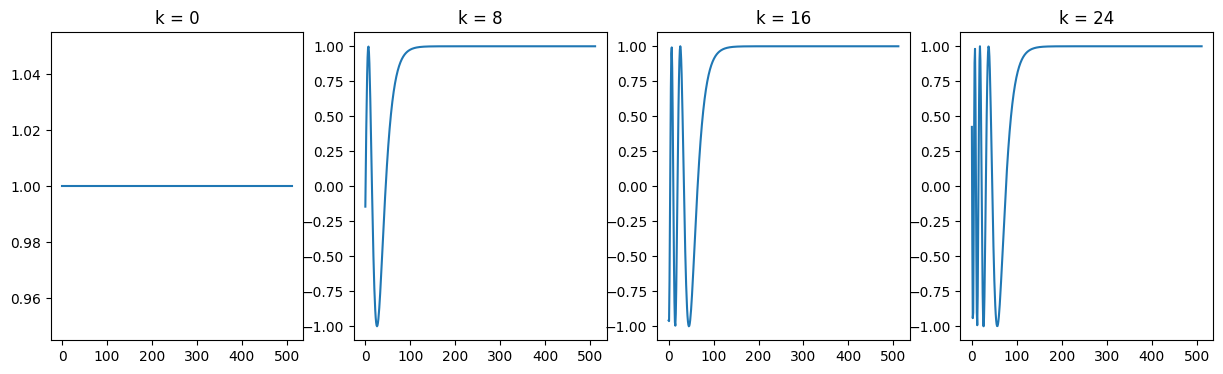

In [9]:
def plotCosinusoid(k, d=512, n=10000):
    i = np.arange(0, d, 1)
    denominator = np.power(n, 2*i/d)
    y = np.cos(k/denominator)
    plt.plot(i, y)
    plt.title('k = ' + str(k))
 
fig = plt.figure(figsize=(15, 4))    
for n in range(4):
    plt.subplot(141 + n)
    plotCosinusoid(8*n)

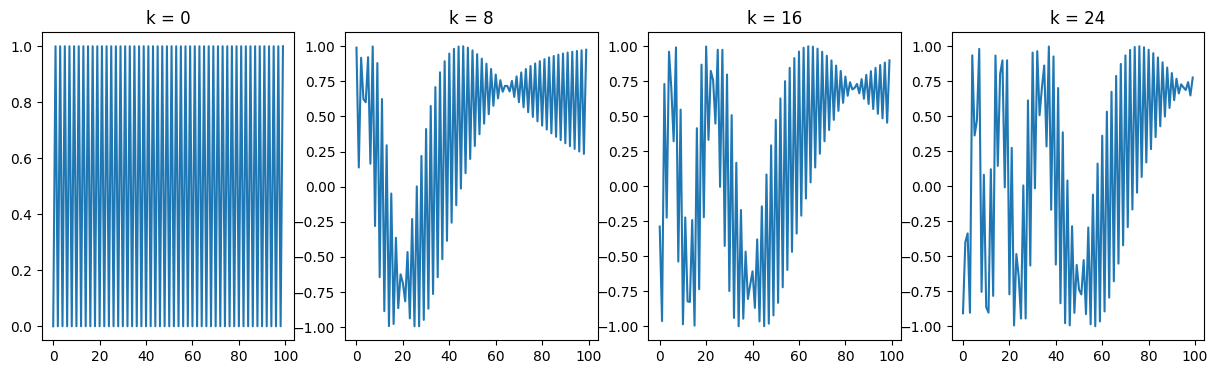

In [26]:
def plotPosEncoding(k, d=512, n=10000):
    y = []
    m = 100
    for i in np.arange(0, m, 1):
        denominator = np.power(n, 2*i/d)
        if i%2 == 0:
            y.append(np.sin(k/denominator))
        else:
            y.append(np.cos(k/denominator))
    y = np.array(y)
    plt.plot(np.arange(0, m, 1), y)
    plt.title('k = ' + str(k))
 
fig = plt.figure(figsize=(15, 4))    
for n in range(4):
    plt.subplot(141 + n)
    plotPosEncoding(8*n)

You can see that each position $k$ corresponds to a different sinusoid, which encodes a single position into a vector. If you look closely at the positional encoding function, you can see that the wavelength for a fixed $i$ is given by:

$$
\lambda_i = 2\pi\> n^{2i/d}
$$

Hence, the wavelengths of the sinusoids form a geometric progression and vary from $2 \pi$  to $2 \pi n$. The scheme for positional encoding has a number of advantages.

- The sine and cosine functions have values in [-1, 1], which keeps the values of the positional encoding matrix in a normalized range.
- As the sinusoid for each position is different, you have a unique way of encoding each position.
- You have a way of measuring or quantifying the similarity between different positions, hence enabling you to encode the relative positions of words.

## Visualizing the Positional Matrix

Let’s visualize the positional matrix on bigger values. Use Python’s matshow() method from the matplotlib library. Setting n=10,000 as done in the original paper, you get the following:

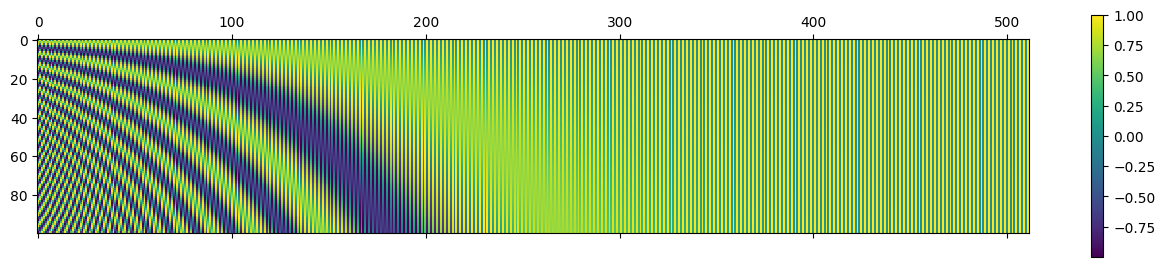

In [21]:
P = getPositionEncoding(seq_len=100, d=512, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

## Relative Positioning

Another characteristic of sinusoidal positional encoding is that it allows the model to attend relative positions effortlessly. Here is a quote from the original paper (Vaswani et al.):

> We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$

This request explain the use of the pair sine-cosine functions. Infact it is possible to verify that For every sine-cosine pair corresponding to frequency $\omega_k$, there is a linear transformation $M \in \mathbb{R}^{2\times2}$  (independent of $t$) where the following equation holds. 

$$
M.\begin{bmatrix}
	    \sin(\omega_k . t) \\
	    \cos(\omega_k . t)
	\end{bmatrix} = \begin{bmatrix}
	    \sin(\omega_k . (t + \phi)) \\
	    \cos(\omega_k . (t + \phi))
	\end{bmatrix}
$$    

We refer [here](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/) for a short demonstration and [here](https://blog.timodenk.com/linear-relationships-in-the-transformers-positional-encoding/) for details.

## Positional Encoding with Keras

In [8]:
import tensorflow as tf
from tensorflow import convert_to_tensor, string
from tensorflow.keras.layers import TextVectorization, Embedding, Layer
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

### The Text Vectorization Layer

Let’s start with a set of English phrases that are already preprocessed and cleaned. The text vectorization layer creates a dictionary of words and replaces each word with its corresponding index in the dictionary. Let’s see how you can map these two sentences using the text vectorization layer:

- I am a robot
- you too robot

Note the text has already been converted to lowercase with all the punctuation marks and noise in the text removed. Next, convert these two phrases to vectors of a fixed length 5. The TextVectorization layer of Keras requires a maximum vocabulary size and the required length of an output sequence for initialization. The output of the layer is a tensor of shape:

`(number of sentences, output sequence length)`

The following code snippet uses the adapt method to generate a vocabulary. It next creates a vectorized representation of the text.

In [9]:
output_sequence_length = 5
vocab_size = 10
sentences = [["I am a robot"], ["you too robot"]]
sentence_data = Dataset.from_tensor_slices(sentences)
# Create the TextVectorization layer
vectorize_layer = TextVectorization(
                  output_sequence_length=output_sequence_length,
                  max_tokens=vocab_size)
# Train the layer to create a dictionary
vectorize_layer.adapt(sentence_data)
# Convert all sentences to tensors
word_tensors = convert_to_tensor(sentences, dtype=tf.string)
# Use the word tensors to get vectorized phrases
vectorized_words = vectorize_layer(word_tensors)
print("Vocabulary: ", vectorize_layer.get_vocabulary())
print("Vectorized words: ", vectorized_words)

Vocabulary:  ['', '[UNK]', 'robot', 'you', 'too', 'i', 'am', 'a']
Vectorized words:  tf.Tensor(
[[5 6 7 2 0]
 [3 4 2 0 0]], shape=(2, 5), dtype=int64)


### The Embedding Layer

The Keras Embedding layer converts integers to dense vectors. This layer maps these integers to random numbers, which are later tuned during the training phase. However, you also have the option to set the mapping to some predefined weight values (shown later). To initialize this layer, you need to specify the maximum value of an integer to map, along with the length of the output sequence.

**The Word Embeddings**

Let’s see how the layer converts the vectorized_text to tensors.


In [10]:
output_length = 6
word_embedding_layer = Embedding(vocab_size, output_length)
embedded_words = word_embedding_layer(vectorized_words)
print(embedded_words)

tf.Tensor(
[[[ 0.00843637  0.03633903  0.03046563  0.01467774  0.04840115
    0.01310017]
  [ 0.02486381 -0.03836963  0.03451294 -0.00488262 -0.03683652
    0.0314327 ]
  [-0.04950925 -0.03003483 -0.03072195 -0.01188693  0.0023609
    0.0398864 ]
  [ 0.03246522 -0.02525061 -0.00078107  0.00674218  0.01141181
   -0.01297218]
  [-0.03590553 -0.02914858 -0.0034699   0.01310959  0.01270381
   -0.00217187]]

 [[ 0.03150269 -0.04169689  0.01078688 -0.026595    0.01968913
    0.00631243]
  [-0.04548572  0.03965003 -0.04684262  0.0339019   0.0482757
    0.03766214]
  [ 0.03246522 -0.02525061 -0.00078107  0.00674218  0.01141181
   -0.01297218]
  [-0.03590553 -0.02914858 -0.0034699   0.01310959  0.01270381
   -0.00217187]
  [-0.03590553 -0.02914858 -0.0034699   0.01310959  0.01270381
   -0.00217187]]], shape=(2, 5, 6), dtype=float32)


**The Position Embeddings**

You also need the embeddings for the corresponding positions. The maximum positions correspond to the output sequence length of the TextVectorization layer.

In [11]:
position_embedding_layer = Embedding(output_sequence_length, output_length)
position_indices = tf.range(output_sequence_length)
embedded_indices = position_embedding_layer(position_indices)
print(embedded_indices)

tf.Tensor(
[[ 0.02741555  0.04389599 -0.020432    0.00319492 -0.0476212   0.01075543]
 [-0.0343771   0.03763329  0.02781442 -0.04642353 -0.04239836 -0.03648805]
 [ 0.04768663 -0.00387352  0.01221979  0.00385567  0.01255618 -0.00178599]
 [-0.00653341 -0.01102237  0.040014    0.0157442  -0.01123246  0.02886588]
 [-0.04149788  0.03917277 -0.04523641 -0.04617521 -0.01463423  0.03713242]], shape=(5, 6), dtype=float32)


**The Output of Positional Encoding Layer in Transformers**

In a transformer model, the final output is the sum of both the word embeddings and the position embeddings. Hence, when you set up both embedding layers, you need to make sure that the output_length is the same for both.

In [12]:
final_output_embedding = embedded_words + embedded_indices
print("Final output: ", final_output_embedding)

Final output:  tf.Tensor(
[[[ 0.03585192  0.08023503  0.01003363  0.01787265  0.00077995
    0.0238556 ]
  [-0.00951329 -0.00073634  0.06232736 -0.05130615 -0.07923488
   -0.00505535]
  [-0.00182263 -0.03390834 -0.01850216 -0.00803126  0.01491709
    0.03810041]
  [ 0.02593182 -0.03627298  0.03923292  0.02248638  0.00017935
    0.01589371]
  [-0.0774034   0.01002419 -0.0487063  -0.03306562 -0.00193042
    0.03496054]]

 [[ 0.05891824  0.0021991  -0.00964512 -0.02340008 -0.02793207
    0.01706786]
  [-0.07986282  0.07728332 -0.0190282  -0.01252163  0.00587734
    0.00117409]
  [ 0.08015185 -0.02912413  0.01143872  0.01059785  0.02396799
   -0.01475817]
  [-0.04243894 -0.04017095  0.0365441   0.02885379  0.00147135
    0.02669401]
  [-0.0774034   0.01002419 -0.0487063  -0.03306562 -0.00193042
    0.03496054]]], shape=(2, 5, 6), dtype=float32)


## Reference and Credits

- Jason Brownlee, **[A Gentle Introduction to Positional Encoding in Transformer Models, Part 1](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/)**, Machine Learning Mastery
---
- Jason Brownlee, **[A Gentle Introduction to Positional Encoding in Transformer Models, Part 2](https://machinelearningmastery.com/the-transformer-positional-encoding-layer-in-keras-part-2/)**, Machine Learning Mastery
---
- Timo Denk, **[Linear Relationships in the Transformer’s Positional Encoding](https://blog.timodenk.com/linear-relationships-in-the-transformers-positional-encoding/)**, Timo Denk's Blog
---
- Amirhossein Kazemnejad, **[heTransformer Architecture: The Positional Encodingre](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)**, Amirhossein Kazemnejad's Blog
---
- Ashish Vaswani et al., **[Attention is All You Need](https://arxiv.org/abs/1706.03762)**


## Appendix

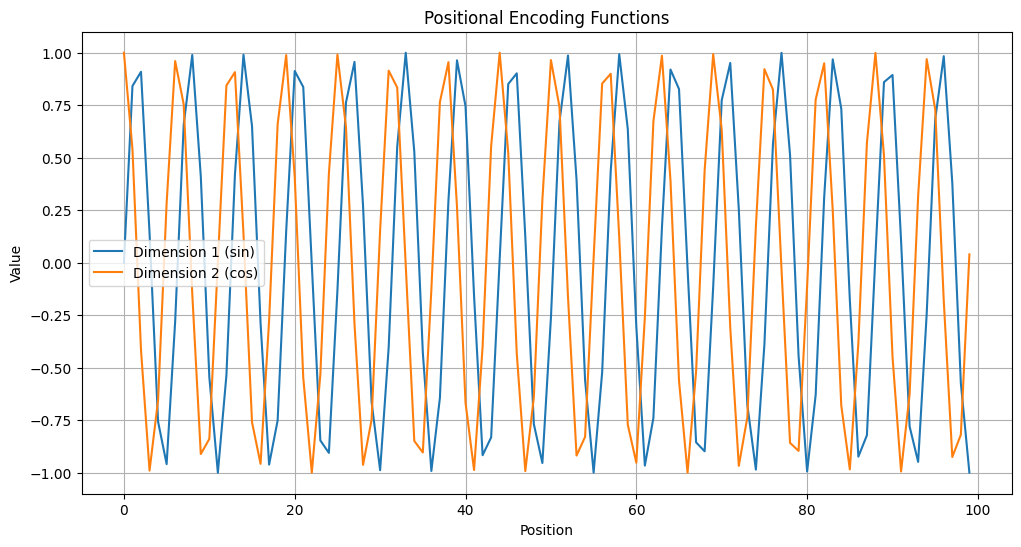

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(max_seq_len, d_model):
    position = np.arange(0, max_seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pos_enc = np.zeros((max_seq_len, d_model))
    pos_enc[:, 0::2] = np.sin(position * div_term)
    pos_enc[:, 1::2] = np.cos(position * div_term)
    return pos_enc

max_seq_len = 100  # Maximum sequence length
d_model = 512       # Dimension of the positional encoding

# Generate positional encoding
pos_enc = positional_encoding(max_seq_len, d_model)

# Plot positional encoding functions for the first two dimensions
plt.figure(figsize=(12, 6))
plt.plot(np.arange(max_seq_len), pos_enc[:, 0], label="Dimension 1 (sin)")
plt.plot(np.arange(max_seq_len), pos_enc[:, 1], label="Dimension 2 (cos)")
plt.title("Positional Encoding Functions")
plt.xlabel("Position")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
